Initiliaze and prepare all models

In [1]:
# ~~~~~~~~~~~~~~~~
# PyTorch Model

import torch
import yaml
from models.decoder import architectures

with open("models/decoder/decoder_params.yaml") as file:
    params = yaml.safe_load(file)

decoder = architectures.LightningDecoderNet(params["inner_dims"], params["seq_len"], params["learning_rate"])
decoder.load_state_dict(torch.load("models/decoder/decoder.pth"))
decoder.eval();

decoder_denoise = architectures.LightningDecoderNet(params["inner_dims"], params["seq_len"], params["learning_rate"])
decoder_denoise.load_state_dict(torch.load("models/decoder/decoder_denoise.pth"))
decoder_denoise.eval();

# ~~~~~~~~~~~~~~~~
# Kernel DM+V

from models.kernel_dmv.my_kernel_dmv import KernelDMV
kdm = KernelDMV()

# ~~~~~~~~~~~~~~~~
# GMRF

from models.gmrf.my_gmrf import myGMRF
gmrf = myGMRF()

### Data & Metrics

Specify data

In [2]:
from torch.utils import data
from data.gdm_dataset import GasDataSet

dataset = GasDataSet("data/30x25/test.pt")

Specify metrics

In [3]:
import gdm_metrics

rmse = {"decoder": 0,
        "decoder_denoise": 0,
        "gmrf": 0,
        "kdm": 0}

kld = {"decoder": 0,
       "decoder_denoise": 0,
       "gmrf": 0,
       "kdm": 0}

### Run

In [6]:
from tqdm import tqdm

list_of_models = [
                  "decoder",
                  #"decoder_denoise",
                  #"gmrf",
                  #"kdm",
                 ]

dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X, y in tqdm(dataloader):
    with torch.no_grad(): 
        if "decoder" in list_of_models:
            y_decoder = decoder(X.squeeze(1))
            rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
            kld["decoder"] += gdm_metrics.kld(y_decoder, y)
        
        if "decoder_denoise" in list_of_models:
            y_decoder_denoise = decoder_denoise(X.squeeze(1))
            rmse["decoder_denoise"] += gdm_metrics.rmse(y_decoder_denoise, y)
            kld["decoder_denoise"] += gdm_metrics.kld(y_decoder_denoise, y)
        
        if "gmrf" in list_of_models:
            y_gmrf = calculate_GMRF(y.squeeze())[None,None,:]  # add two empty dimensions to be consistent with y.shape
            rmse["gmrf"] += gdm_metrics.rmse(y_gmrf, y)
            kld["gmrf"] += gdm_metrics.kld(y_gmrf, y)
            
        if "kdm" in list_of_models:
            y_kdm = kdm.calculate(y.squeeze())[None,None,:]    # add two empty dimensions to be consistent with y.shape
            rmse["kdm"] += gdm_metrics.rmse(y_kdm, y)
            kld["kdm"] += gdm_metrics.kld(y_kdm, y)

100%|████████████████████████████████████| 32400/32400 [02:36<00:00, 206.66it/s]


In [4]:
from tqdm import tqdm

list_of_models = [
                  "decoder",
                  "decoder_denoise",
                  "gmrf",
                  "kdm",
                 ]

dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X, y in tqdm(dataloader):
    with torch.no_grad(): 
        if "decoder" in list_of_models:
            y_decoder = model(X.squeeze(1))
            rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
            kld["decoder"] += gdm_metrics.kld(y_decoder, y)
        
        if "decoder_denoise" in list_of_models:
            y_decoder_denoise = model_denoise(X.squeeze(1))
            rmse["decoder_denoise"] += gdm_metrics.rmse(y_decoder_denoise, y)
            kld["decoder_denoise"] += gdm_metrics.kld(y_decoder_denoise, y)
        
        if "gmrf" in list_of_models:
            y_gmrf = calculate_GMRF(y.squeeze())[None,None,:]  # add two empty dimensions to be consistent with y.shape
            rmse["gmrf"] += gdm_metrics.rmse(y_gmrf, y)
            kld["gmrf"] += gdm_metrics.kld(y_gmrf, y)
            
        if "kdm" in list_of_models:
            y_kdm = kdm.calculate(y.squeeze())[None,None,:]    # add two empty dimensions to be consistent with y.shape
            rmse["kdm"] += gdm_metrics.rmse(y_kdm, y)
            kld["kdm"] += gdm_metrics.kld(y_kdm, y)

100%|██████████████████████████████████████████████████████████████████| 32400/32400 [16:45:58<00:00,  1.86s/it]


### Evaluation

In [5]:
# Print results
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(dataloader)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(dataloader)}")

########
# RMSE #
########
decoder: 	 0.07057706266641617
decoder_denoise: 	 0.07306750863790512
gmrf: 	 0.11100773428192476
kdm: 	 0.11176697431124034
########
# KL D #
########
decoder: 	 0.0032490254379808903
decoder_denoise: 	 0.003500421764329076
gmrf: 	 0.008397885626507435
kdm: 	 0.00816277310695924


# Visualization

In [ ]:
def plot_dict(input_dict, figsize, cbar_base_col=0):
    """ Plots the input of a dict. The dict should contain GDM data.
    
    Input:
    input_dict: ...
    figsize: ... (automatically in the future?)
    cbar_base_col: Which col should be used as baseline vmin and vmax of plt.imshow.
    """
    
    rows = len(next(iter(input_dict.values())))
    cols = len(input_dict)

    fig, axes = plt.subplots(rows, len(input_dict), constrained_layout=True, figsize=figsize)  
    
    # Loop over rows (amount of samples)
    for row in range(rows):
        vmin=None
        vmax=None

        vmin = input_dict[list(input_dict.keys())[cbar_base_col]][row].min()
        vmax = input_dict[list(input_dict.keys())[cbar_base_col]][row].max()   
        
        # Loop over cols (amount of models)
        for col, i in zip(input_dict, range(cols)):
            try:
                # Try for multiple rows
                plot_gdm(input_dict[col][row].squeeze(), axes[row][i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[row][i].set_title(col)
        
            except:
                # otherwise only single row
                plot_gdm(input_dict[col][row].squeeze(), axes[i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[i].set_title(col)
    
    return fig, axes

In [21]:
a = list(range(5))
b = list(range(5))

[x for x in a]

SyntaxError: invalid syntax (3111986843.py, line 4)

In [26]:
[abs(decoder(x.squeeze(1)-y)) for x, y in zip(X_list, y_list)]

RuntimeError: The size of tensor a (5) must match the size of tensor b (25) at non-singleton dimension 3

In [28]:
decoder(X_list[0].squeeze(1)).shape

torch.Size([1, 30, 25])

In [30]:
y_list[0].shape

torch.Size([1, 1, 30, 25])

In [ ]:
[decoder(x.squeeze(1)) for x in X_list],

In [39]:
indices = [1,5,7,8,9]

result = [X_list[i] for i in indices]

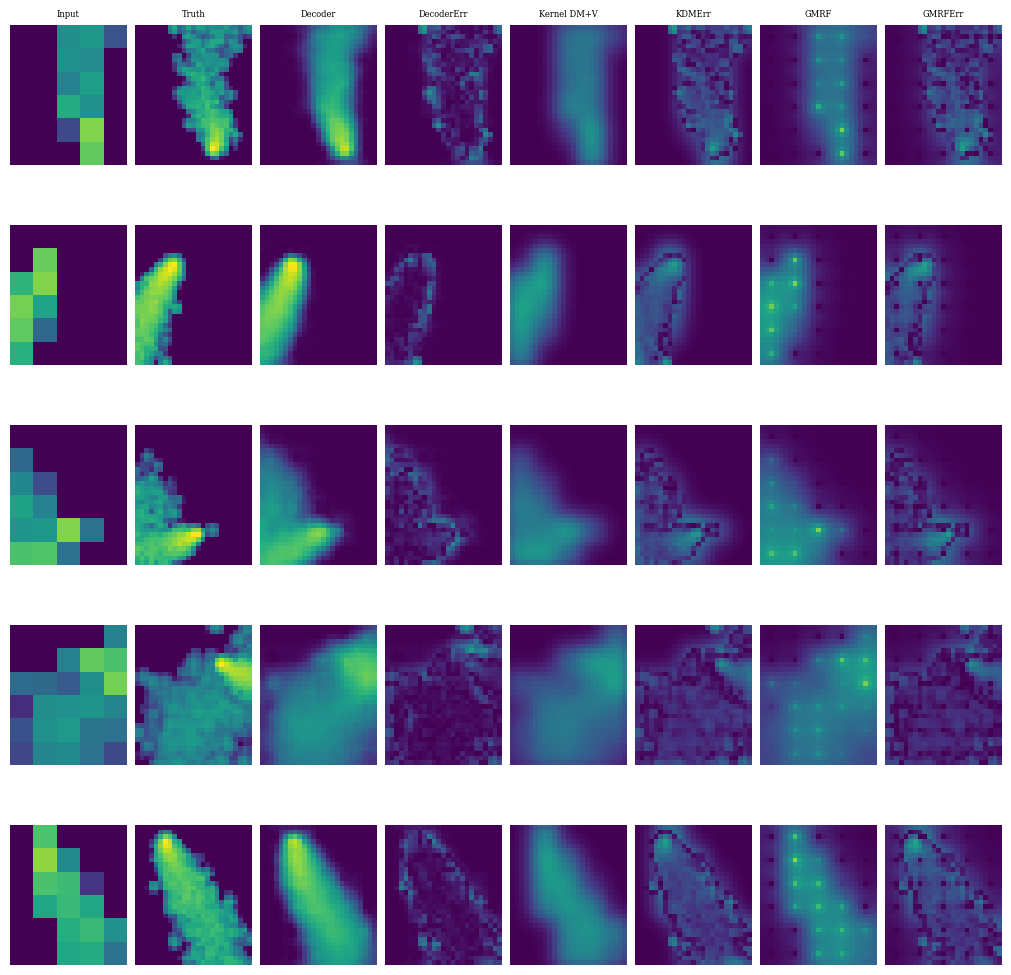

In [43]:
from utils import plot_dict, draw_random_samples

#X_list, y_list = draw_random_samples(10, dataset)


indices = [1,5,7,8,9]
X_l = [X_list[i] for i in indices]
y_l = [y_list[i] for i in indices]

data = {
        "Input": X_l,
        "Truth": y_l,
        "Decoder": [decoder(x.squeeze(1)) for x in X_l],
        "DecoderErr": [abs(decoder(x.squeeze(1)).unsqueeze(0)-y) for x, y in zip(X_l, y_l)],
        "Kernel DM+V": [kdm.calculate(x.squeeze()) for x in X_l],
        "KDMErr": [abs(kdm.calculate(x.squeeze()).unsqueeze(0)-y) for x, y in zip(X_l, y_l)],
        "GMRF": [gmrf.calculate(x.squeeze()) for x in X_l],
        "GMRFErr": [abs(gmrf.calculate(x.squeeze()).unsqueeze(0)-y) for x, y in zip(X_l, y_l)],
        }


import matplotlib as mpl

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

fig, axes = plot_dict(data, [10,10], 1,);
mpl.pyplot.savefig("pgf/comparison/comparison.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)